<a href="https://colab.research.google.com/github/ganuwoahh/tdlta/blob/main/Week4_LSTM_GRU_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM vs GRU

LSTM and GRU are both forms of RNNs that incorporate some sort of memory functionality to combat Vanishing Gradient.

LSTM stands for Long Short Term Memory. It has 3 gates, input, forget & output, that decide what information is kept, forgotten and outputted respectively.

It consists of two main states. The cell state and the hidden state. The cell state is the memory and has the information gathered by the previous cell. The hidden state is the current state of the cell.

GRU stands for Gated Recurrent Memory. It has 2 gates, reset and update, that decide how much of the previous memory to forget and how much to keep along with the current information respectively.

There is only one state in a GRU. Namely, hidden state. This means that both long and short term dependencies are captured by this state. This is much quicker than LSTM but does struggle to keep up with LSTM as the dependencies get longer.

The problem of Vanishing Gradients is solved by using gates like this. This is because they control the gradients during the forward and backward passes. They can vanish the gradients if they think it doesn't contribute anything relevant. Moreover, they can amplify the gradient if it seems important.

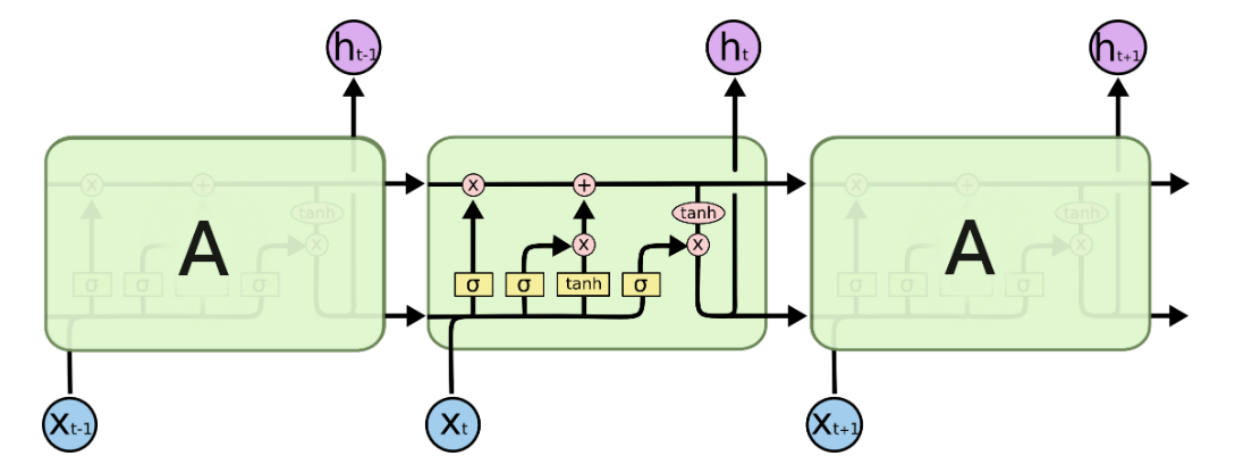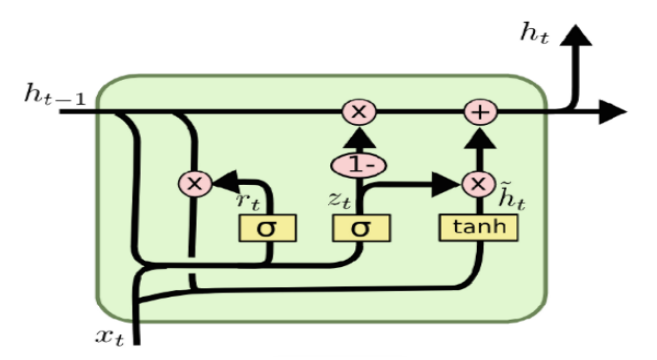

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from transformers import PreTrainedTokenizerFast
import json
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

We're going to be comparing LSTM and GRU at 2 different tasks. Sentiment Analysis and Speech Recognition.

In [3]:
df = pd.read_csv('train_data.csv')
df.head()

,sentence,sentiment
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


As we can see there are 2 columns, sentence, which is just the tweet that the user tweeted after preprocessing, and sentiment, which is a binary attribute detailing positive (1) or negative (0) sentiment.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1523975 entries, 0 to 1523974
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentence   1523975 non-null  object
 1   sentiment  1523975 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 23.3+ MB


In [5]:
with open('vocab.json', 'r') as f:
    tokenizer_config = json.load(f)

tokenizer = PreTrainedTokenizerFast(tokenizer_file="/content/vocab.json")

This dataset comes with a predefined vocabulary so we don't have to craft one ourselves. However, this also means we'll have to train in batches since we'll run out of RAM if we try and train this all at once.

i.e. we're comparing each token to each of the 30000 words. We need to keep the previous tokens in RAM because of any possible dependency between them.

In [6]:
#definitions
max_features = 30000
maxlen = 50
embedding_dims = 128
batch_size = 64
epochs = 5

In [8]:
def batch_tokenize(sentences, batch_size=5000):
    input_ids = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        batch = sentences[i : i + batch_size]
        encodings = tokenizer(batch, padding=False, truncation=True, max_length=maxlen)
        input_ids.extend(encodings['input_ids'])
    return np.array(pad_sequences(input_ids, maxlen=maxlen, padding='post'))

X = batch_tokenize(df['sentence'].tolist(), batch_size=5000)
y = df['sentiment'].values

100%|██████████| 305/305 [01:33<00:00,  3.26it/s]


So, we're going to compare 5000 tokens at once instead of the entire dataset. 5000\*30000 <<<< 1600000\*30000

In [9]:
def create_lstm_model():
    model = Sequential([
        Embedding(max_features, embedding_dims, input_length=maxlen), #each vector is represented by a 128 dim vector
        LSTM(64, return_sequences=True), #return sequences very important since more than 1 LSTM layer
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), #binary ce because binary classification
        metrics=['accuracy']
    )
    return model

In [26]:
def create_gru_model(): #note how both of these models are the same just swapping the cells out for each other.
    model = Sequential([
        Embedding(max_features, embedding_dims, input_length=maxlen),
        GRU(64, return_sequences=True),
        GRU(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model

In [11]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\nTraining {model_name}...")
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        verbose=1
    )
    return history

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
lstm_model = create_lstm_model()
lstm_history = train_and_evaluate(lstm_model, X_train, y_train, X_val, y_val, "LSTM")


Training LSTM...
Epoch 1/5
19050/19050 ━━━━━━━━━━━━━━━━━━━━ 232s 12ms/step - accuracy: 0.5054 - loss: 0.6922 - val_accuracy: 0.5023 - val_loss: 0.6931
Epoch 2/5
19050/19050 ━━━━━━━━━━━━━━━━━━━━ 228s 12ms/step - accuracy: 0.6213 - loss: 0.5952 - val_accuracy: 0.8194 - val_loss: 0.3984
Epoch 3/5
19050/19050 ━━━━━━━━━━━━━━━━━━━━ 227s 12ms/step - accuracy: 0.8306 - loss: 0.3788 - val_accuracy: 0.8267 - val_loss: 0.3860
Epoch 4/5
19050/19050 ━━━━━━━━━━━━━━━━━━━━ 226s 12ms/step - accuracy: 0.8485 - loss: 0.3445 - val_accuracy: 0.8268 - val_loss: 0.3866
Epoch 5/5
19050/19050 ━━━━━━━━━━━━━━━━━━━━ 265s 12ms/step - accuracy: 0.8648 - loss: 0.3131 - val_accuracy: 0.8234 - val_loss: 0.3948


In [27]:
gru_model = create_gru_model()
gru_history = train_and_evaluate(gru_model, X_train, y_train, X_val, y_val, "GRU")


Training GRU...
Epoch 1/5
19050/19050 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5015 - loss: 0.6932

KeyboardInterrupt: 

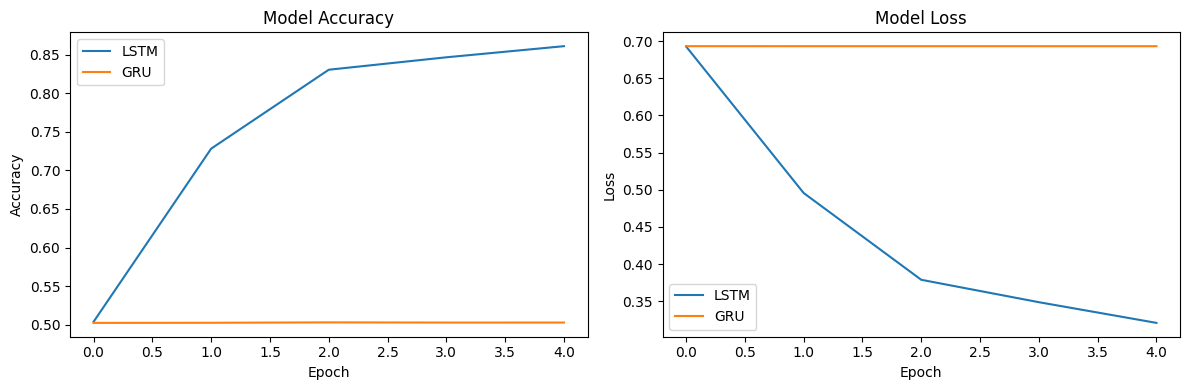

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='LSTM')
plt.plot(gru_history.history['accuracy'], label='GRU')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='LSTM')
plt.plot(gru_history.history['loss'], label='GRU')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Clearly, GRU is not comparable to LSTM in this experiment.

LSTM has a much easier time capturing long term dependencies than GRU. This is because of how it sacrifices speed for dependencies.

GRU is barely better than a coin flip in this example. Some reasons might be low epochs, having to use small batches because of RAM restrictions, most tweets in this dataset being quite long (GRU doesn't like long dependencies).